*I tried to predict the complaint classification of bank customers with an ensemble-based model.*

First of all, I applied several <b>preprocessing</b> operations (I tried stemming and lemmatization, but there was no betterment in the F1 score), then following models and methods

<hr>

#### <span style="color:#e74c3c;"> Model 1 </span> Transformer Features, CatBoostClassifier
* I used <b>a pretrained embeddings</b> for the text feature extraction stage [1],
* <b>PCA for dimensionality reduction </b> (applied the output of pretrained embeddings with 300 components),

#### <span style="color:#e74c3c;"> Model 2 </span> TfidfVectorizer, Logistic Regression
* Created text features with <b>TfidfVectorizer</b>
* Predicted with Logistic Regression (with simple tuned parameter)

#### <span style="color:#2980b9;"> Final Weighted Average Ensemble Model</span> 
* Used the first model weight of 32 % and the second model weight of 68 %

<hr>


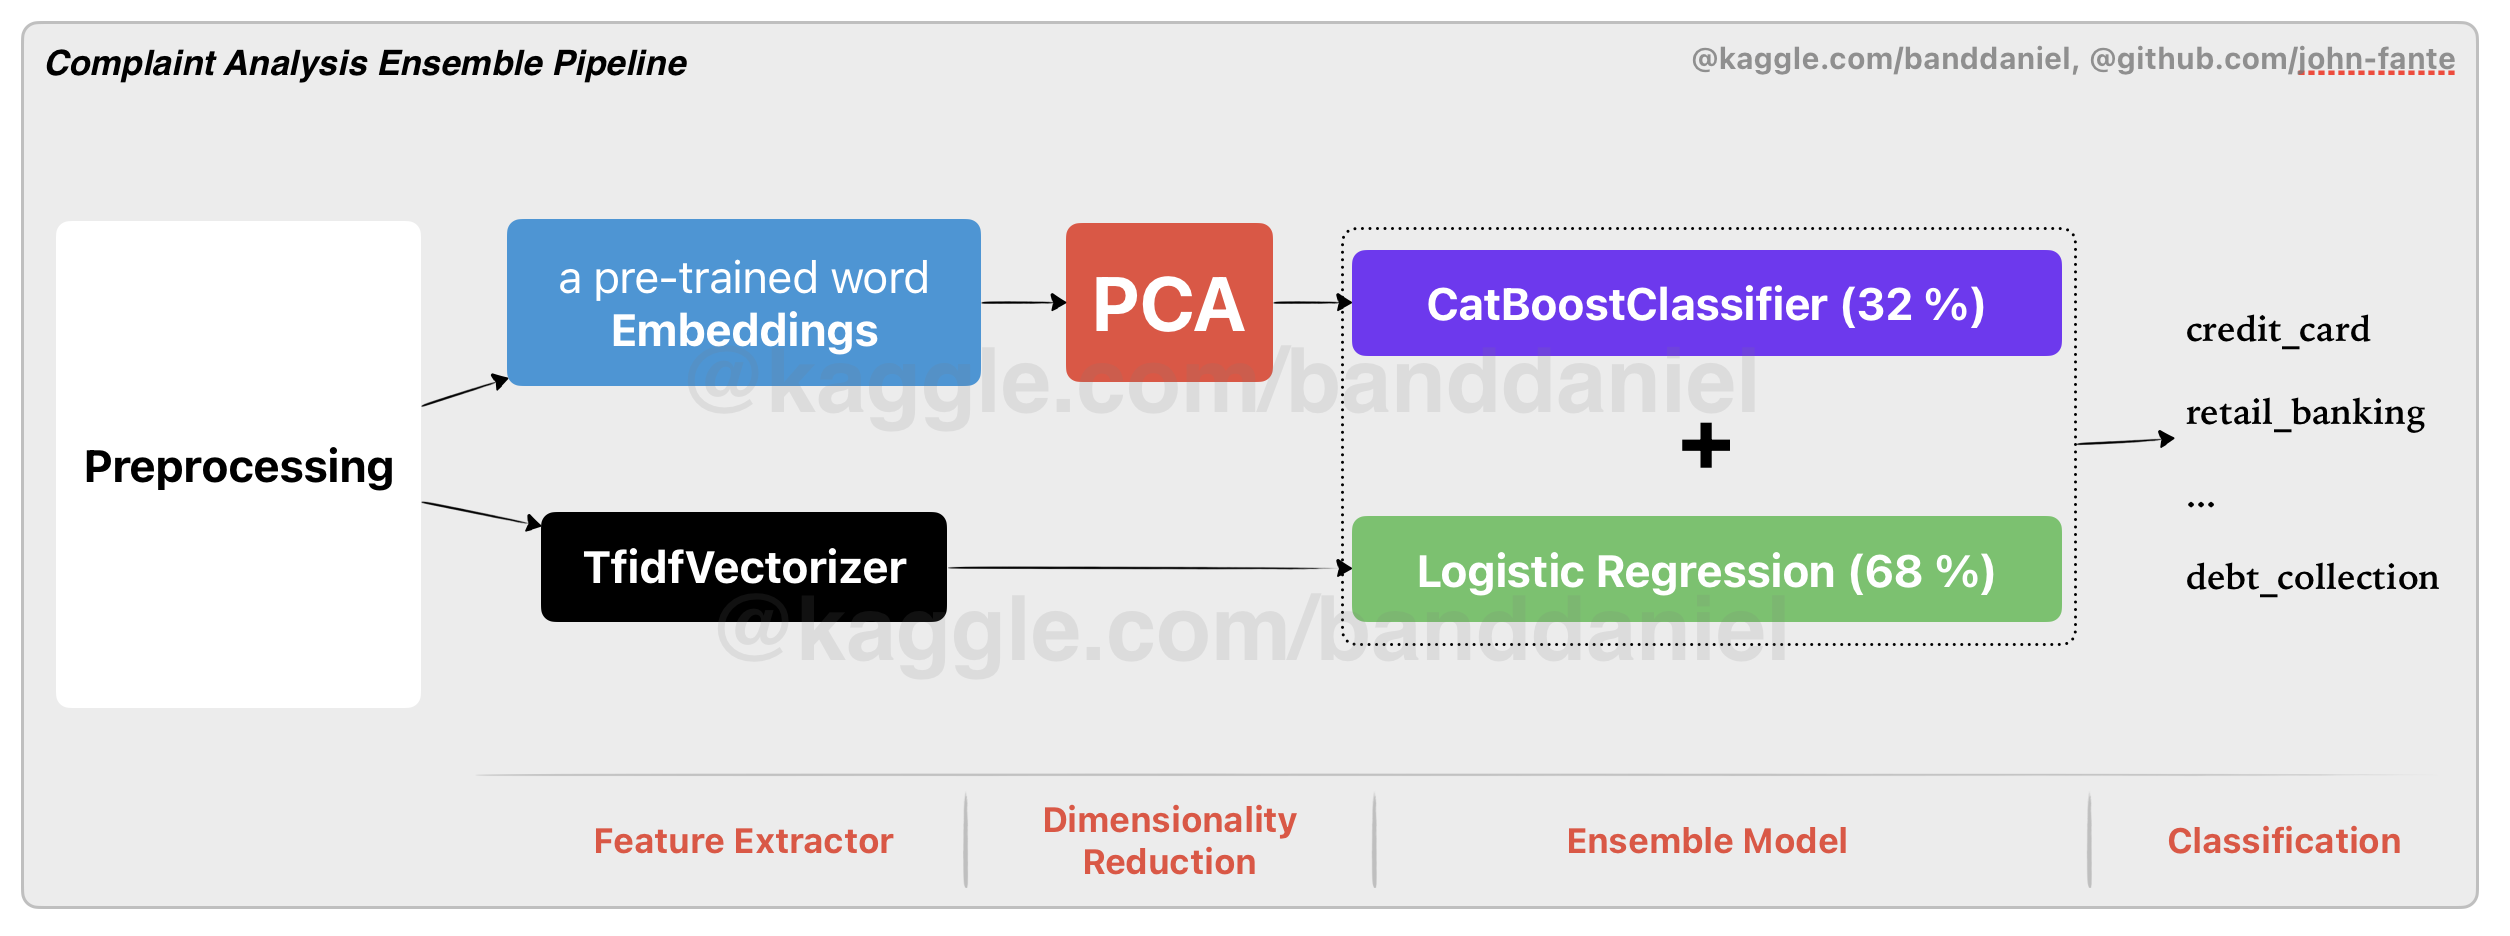
*Figure 1: proposed ensemble classification pipeline*


## My Another Projects
* [Gemma 2B Text Summarization w/Zero-Shot Prompting](https://www.kaggle.com/code/banddaniel/gemma-2b-text-summarization-w-zero-shot-prompting)
* [Rating Prediction w/SentenceTransformer, CatBoost](https://www.kaggle.com/code/banddaniel/rating-prediction-w-sentencetransformer-catboost)
* [Sentiment Analysis w/CatBoostClassifier](https://www.kaggle.com/code/banddaniel/sentiment-analysis-w-catboostclassifier)

## References
1. https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [1]:
from IPython.display import clear_output
!pip install sentence-transformers
clear_output()

In [2]:
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import  stopwords
import string
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

from sentence_transformers import SentenceTransformer

# feature extractor
emmedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

SEED = 32

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
data = pd.read_csv('/kaggle/input/bank-customer-complaint-analysis/complaints.csv')
data = data.drop_duplicates(subset = ['narrative'], keep = 'first').reset_index(drop = True)
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


# <span style="color:#e74c3c;"> Preprocessing </span>

In [4]:
# preprocessing functions
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\w*xx+\w*', '', text)
    return text


def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


# applying preprocessing functions
data_processed = data.copy()
data_processed['narrative'] = data_processed['narrative'].apply(text_preprocessing).apply(drop_stopwords)


# label encoding
LE = LabelEncoder()
data_processed['encoded_product'] = LE.fit_transform(data_processed['product'])


# a function for calculating and plotting predictions 
def plot_prediction_results(model, X_data, y_data, target_names = list(LE.classes_)):
    pred = model.predict(X_data)
    
    mse = mean_squared_error(y_data, pred)
    f1 = f1_score(y_data, pred, average = 'weighted')
    acc = accuracy_score(y_data, pred)
    cm = confusion_matrix(y_data, pred)
    
    clf = classification_report(y_data, pred, target_names = target_names)
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay(cm, display_labels = target_names)
    fig, axs = plt.subplots(figsize=(4,4))
    cmd.plot(ax=axs, cmap="bone", xticks_rotation="vertical", colorbar = False)

In [5]:
# data after preprocessing operations
data_processed.head()

,product,narrative,encoded_product
0,credit_card,purchase order day shipping amount receive pro...,0
1,credit_card,forwarded message date tue subject please inve...,0
2,retail_banking,forwarded message cc sent friday pdt subject f...,4
3,credit_reporting,payment history missing credit report speciali...,1
4,credit_reporting,payment history missing credit report made mis...,1


In [6]:
# train and test splitting
type_train_data, type_test_data = train_test_split(data_processed, test_size = 0.2, random_state = SEED, shuffle = False)

type_train_data = type_train_data.reset_index(drop = True)
type_test_data = type_test_data.reset_index(drop = True)

print('train sample size\t', type_train_data.shape[0])
print('test sample size\t', type_test_data.shape[0])

train sample size	 99578
test sample size	 24895


# <span style="color:#e74c3c;"> SentenceTransformer </span> Feature Extractor

In [7]:
# creating text features (384 features)
train_embeddings = emmedding_model.encode(list(type_train_data['narrative'].values), show_progress_bar = True)
test_embeddings = emmedding_model.encode(list(type_test_data['narrative'].values), show_progress_bar = True)
    

# dimensionality reduction
pca = PCA(300)

# last text features
train_pca = pca.fit_transform(train_embeddings)
test_pca = pca.transform(test_embeddings)

print('\nbefore PCA, train feature size\t', train_embeddings.shape[1])
print('\nafter PCA, train feature size\t', train_pca.shape[1])

Batches:   0%|          | 0/3112 [00:00<?, ?it/s]

Batches:   0%|          | 0/778 [00:00<?, ?it/s]


before PCA, train feature size	 384

after PCA, train feature size	 300


In [8]:
X_train_pca = train_pca
y_train = type_train_data['encoded_product']

X_test_pca = test_pca
y_test = type_test_data['encoded_product']

# <span style="color:#e74c3c;">Model 1: </span> CatBoostClassifier

In [9]:
# a tuned model
cat_model = CatBoostClassifier(verbose = 500)

# training
cat_model.fit(X_train_pca, y_train)

Learning rate set to 0.100053
0:	learn: 1.4463707	total: 778ms	remaining: 12m 57s
500:	learn: 0.4151129	total: 4m 24s	remaining: 4m 23s
999:	learn: 0.3430488	total: 8m 16s	remaining: 0us


# <span style="color:#e74c3c;"> Model 1: </span> Test Predictions

Mean Squared Error :	0.56799
Weighted F1 Score :	0.831
Accuracy Score :	83.201 %
----------------------------------------------------------------------

 Classification Report:
                      precision    recall  f1-score   support

        credit_card       0.73      0.74      0.73      2006
   credit_reporting       0.88      0.89      0.89     13410
    debt_collection       0.76      0.69      0.72      4394
mortgages_and_loans       0.81      0.82      0.82      3186
     retail_banking       0.80      0.84      0.82      1899

           accuracy                           0.83     24895
          macro avg       0.80      0.80      0.80     24895
       weighted avg       0.83      0.83      0.83     24895

----------------------------------------------------------------------

 Confusion Matrix: 



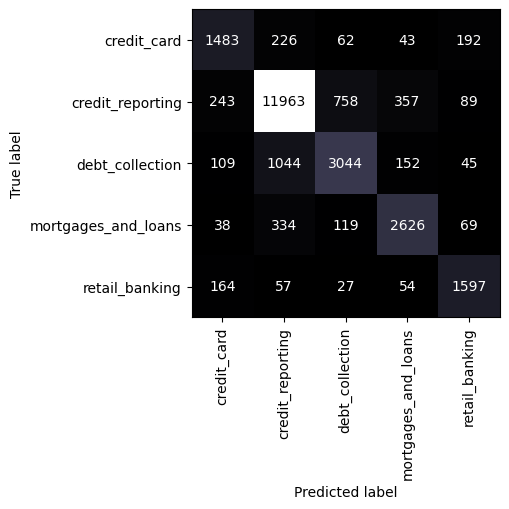

In [10]:
plot_prediction_results(cat_model, X_test_pca, y_test)

# <span style="color:#e74c3c;"> Model 2: </span> LogisticRegression

In [11]:
%%time
log_reg = make_pipeline(TfidfVectorizer(), LogisticRegression(C=2.0, max_iter = 500))
log_reg.fit(type_train_data['narrative'].values, y_train)

CPU times: user 3min 49s, sys: 3min, total: 6min 49s
Wall time: 1min 52s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=2.0, max_iter=500))])

# <span style="color:#e74c3c;"> Model 2: </span> Test Predictions

Mean Squared Error :	0.49038
Weighted F1 Score :	0.850
Accuracy Score :	85.033 %
----------------------------------------------------------------------

 Classification Report:
                      precision    recall  f1-score   support

        credit_card       0.75      0.77      0.76      2006
   credit_reporting       0.89      0.90      0.90     13410
    debt_collection       0.79      0.73      0.76      4394
mortgages_and_loans       0.82      0.84      0.83      3186
     retail_banking       0.83      0.87      0.85      1899

           accuracy                           0.85     24895
          macro avg       0.82      0.82      0.82     24895
       weighted avg       0.85      0.85      0.85     24895

----------------------------------------------------------------------

 Confusion Matrix: 



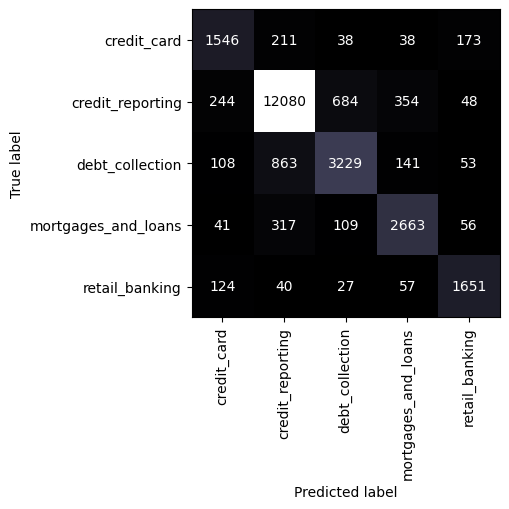

In [12]:
plot_prediction_results(log_reg, type_test_data['narrative'].values, y_test)

# <span style="color:#e74c3c;"> Ensemble </span> Model

In [13]:
# prediction probabilities
pred_proba1 = cat_model.predict_proba(X_test_pca)
pred_proba2 = log_reg.predict_proba(type_test_data['narrative'].values)

In [14]:
# final ensemble predictions
# 32% CatBoostClassifier + 68% Logistic Regression 

final_test_pred_ = (pred_proba1*0.32 + pred_proba2*0.68)
final_test_pred = np.argmax(final_test_pred_, axis = 1)

# <span style="color:#e74c3c;"> Ensemble </span> Test Predictions

Mean Squared Error :	0.46801
Weighted F1 Score :	0.856
Accuracy Score :	85.680 %
----------------------------------------------------------------------

 Classification Report:
                      precision    recall  f1-score   support

        credit_card       0.76      0.78      0.77      2006
   credit_reporting       0.90      0.91      0.90     13410
    debt_collection       0.80      0.74      0.77      4394
mortgages_and_loans       0.83      0.85      0.84      3186
     retail_banking       0.84      0.88      0.86      1899

           accuracy                           0.86     24895
          macro avg       0.83      0.83      0.83     24895
       weighted avg       0.86      0.86      0.86     24895

----------------------------------------------------------------------


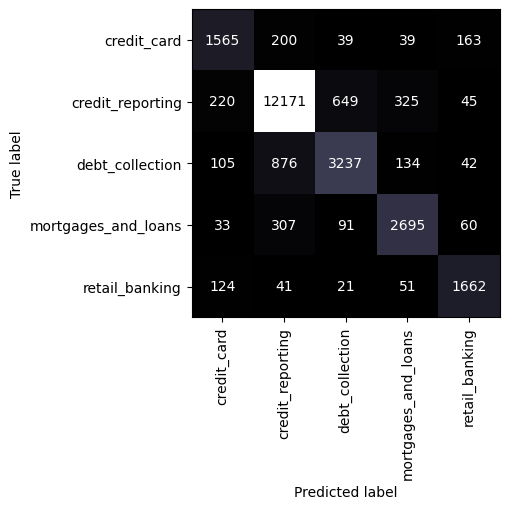

In [15]:
mse = mean_squared_error(y_test, final_test_pred)
f1 = f1_score(y_test, final_test_pred, average = 'weighted')
acc = accuracy_score(y_test, final_test_pred)
cm = confusion_matrix(y_test, final_test_pred)

clf = classification_report(y_test, final_test_pred, target_names = list(LE.classes_))

print('Mean Squared Error :\t{0:.5f}'.format(mse))
print('Weighted F1 Score :\t{0:.3f}'.format(f1))
print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
print('--'*35)
    
print('\n Classification Report:\n',clf)
print('--'*35)


# confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels = list(LE.classes_))
fig, axs = plt.subplots(figsize=(4,4))
cmd.plot(ax=axs, cmap="bone", xticks_rotation="vertical", colorbar = False)